In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from loguru import logger
from sqlalchemy.orm import Session
from Database.database import engine, SessionLocal
from Database.models import DimDate
from helpers import (
    load_user_activity_and_subscription_dfs, 
    calculate_total_lifetime_revenue,
    save_snapshot_to_db, 
    ensure_snapshot_date,
    save_dashboard_metrics_to_db
)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Imports loaded successfully")

Imports loaded successfully


In [2]:
# Load and Explore Data
merged_df = load_user_activity_and_subscription_dfs()

print(f"Loaded {len(merged_df)} activity records")
print(f"Unique users: {merged_df['user_key'].nunique()}")
print(f"\nDataFrame shape: {merged_df.shape}")
print(f"\nColumn names:\n{merged_df.columns.tolist()}")
print(f"\nFirst few rows:")
merged_df.head()

2025-11-28 18:10:55.882 | INFO     | helpers:load_user_activity_and_subscription_dfs:21 - [load_user_activity_and_subscription_dfs] Loaded 49565 activity rows and 5 subscription rows


Loaded 49565 activity records
Unique users: 1000

DataFrame shape: (49565, 21)

Column names:
['fact_user_daily_activity_id', 'user_key', 'date_key', 'subscription_plan_key', 'campaign_key', 'is_premium', 'has_active_subscription', 'logins_count', 'sessions_count', 'minutes_watched', 'lessons_completed', 'quizzes_attempted', 'distinct_courses_accessed', 'active_days_last_30d', 'days_since_last_login', 'is_inactive_7d_flag', 'active_courses_count', 'completed_courses_total', 'created_at', 'base_price', 'billing_cycle']

First few rows:


,fact_user_daily_activity_id,user_key,date_key,subscription_plan_key,campaign_key,is_premium,has_active_subscription,logins_count,sessions_count,minutes_watched,lessons_completed,quizzes_attempted,distinct_courses_accessed,active_days_last_30d,days_since_last_login,is_inactive_7d_flag,active_courses_count,completed_courses_total,created_at,base_price,billing_cycle
0,1,788,20250830,1,18,False,False,2,2,121,3,5,3,19,1,False,3,3,2025-11-28 18:04:42.541913,0.00,None
1,2,921,20250830,3,21,True,False,5,4,49,6,2,3,29,2,False,3,6,2025-11-28 18:04:42.541924,149.99,Annual
2,3,292,20250830,4,27,False,False,0,0,0,0,0,0,1,58,True,0,0,2025-11-28 18:04:42.541928,29.99,Monthly
3,4,456,20250830,1,39,True,True,0,0,0,0,0,0,12,23,True,0,0,2025-11-28 18:04:42.541931,0.00,None
4,5,803,20250830,5,49,True,True,3,1,198,1,5,2,21,4,False,2,1,2025-11-28 18:04:42.541936,299.99,Annual


# RFM ANALYSIS - Updating fact_user_analytics_snapshot

In [3]:
# Calculating total lifetime revenue per user based on billing cycles
revenue_df = calculate_total_lifetime_revenue(merged_df)

print(f"\nRevenue calculated for {len(revenue_df)} users")
print(f"\nRevenue statistics:")
print(revenue_df['total_lifetime_revenue'].describe())
print(f"\nSample revenue data:")
revenue_df.head(10)

2025-11-28 18:10:55.911 | INFO     | helpers:calculate_total_lifetime_revenue:48 - [calculate_total_lifetime_revenue] Processing 39569 premium activity records
2025-11-28 18:10:56.283 | INFO     | helpers:calculate_total_lifetime_revenue:90 - [calculate_total_lifetime_revenue] Sample billing calculations:
2025-11-28 18:10:56.284 | INFO     | helpers:calculate_total_lifetime_revenue:93 -   User 1: 3 monthly periods × $14.99 = $44.97
2025-11-28 18:10:56.284 | INFO     | helpers:calculate_total_lifetime_revenue:93 -   User 1: 1 annual periods × $149.99 = $149.99
2025-11-28 18:10:56.285 | INFO     | helpers:calculate_total_lifetime_revenue:93 -   User 1: 2 monthly periods × $29.99 = $59.98
2025-11-28 18:10:56.286 | INFO     | helpers:calculate_total_lifetime_revenue:93 -   User 1: 1 annual periods × $299.99 = $299.99
2025-11-28 18:10:56.286 | INFO     | helpers:calculate_total_lifetime_revenue:93 -   User 2: 4 monthly periods × $14.99 = $59.96
2025-11-28 18:10:56.295 | INFO     | helpers:c


Revenue calculated for 1000 users

Revenue statistics:
count   1000.00
mean     591.58
std       16.93
min      509.95
25%      584.92
50%      584.92
75%      599.91
max      629.90
Name: total_lifetime_revenue, dtype: float64

Sample revenue data:


,user_key,total_lifetime_revenue,total_billing_cycles
0,1,554.93,7
1,2,599.91,9
2,3,584.92,8
3,4,629.90,10
4,5,599.91,9
5,6,584.92,8
6,7,599.91,9
7,8,584.92,8
8,9,629.90,10
9,10,614.91,9


In [4]:
#Computing basic RFM metrics
def compute_basic_rfm(df: pd.DataFrame, revenue_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute raw RFM metrics from user activity data.
    
    - Recency: days_since_last_login from the MOST RECENT record 
    - Frequency: active_days_last_30d from the MOST RECENT record
    - Monetary: total_lifetime_revenue 
    """
    df['date'] = pd.to_datetime(df['date_key'], format='%Y%m%d')
    
    latest_date = df['date'].max()
    print(f"Latest date in dataset: {latest_date.strftime('%Y-%m-%d')}")
    
    latest_records = df.sort_values('date').groupby('user_key').tail(1)
    
    rfm_df = latest_records[['user_key', 'days_since_last_login', 
                              'active_days_last_30d', 'subscription_plan_key']].copy()
    
    rfm_df.rename(columns={
        'days_since_last_login': 'rfm_recency',
        'active_days_last_30d': 'rfm_frequency'
    }, inplace=True)
    
    rfm_df = pd.merge(
        rfm_df,
        revenue_df[['user_key', 'total_lifetime_revenue']],
        on='user_key',
        how='left'
    )
    
    rfm_df.rename(columns={'total_lifetime_revenue': 'rfm_monetary'}, inplace=True)

    rfm_df['rfm_monetary'] = rfm_df['rfm_monetary'].fillna(0)
    
    print(f"\nComputed RFM for {len(rfm_df)} users")
    print(f"\nRecency stats: Min={rfm_df['rfm_recency'].min()}, "
          f"Mean={rfm_df['rfm_recency'].mean():.1f}, "
          f"Max={rfm_df['rfm_recency'].max()}")
    print(f"Frequency stats: Min={rfm_df['rfm_frequency'].min()}, "
          f"Mean={rfm_df['rfm_frequency'].mean():.1f}, "
          f"Max={rfm_df['rfm_frequency'].max()}")
    print(f"Monetary stats: Min=${rfm_df['rfm_monetary'].min():.2f}, "
          f"Mean=${rfm_df['rfm_monetary'].mean():.2f}, "
          f"Max=${rfm_df['rfm_monetary'].max():.2f}")
    
    inactive_count = (rfm_df['rfm_recency'] > 7).sum()
    inactive_pct = (inactive_count / len(rfm_df)) * 100
    print(f"\nInactive users (>7 days since login): {inactive_count} ({inactive_pct:.1f}%)")
    
    return rfm_df

rfm_df = compute_basic_rfm(merged_df, revenue_df)
rfm_df.head(10)


Latest date in dataset: 2025-11-27

Computed RFM for 1000 users

Recency stats: Min=0, Mean=13.9, Max=60
Frequency stats: Min=0, Mean=13.0, Max=30
Monetary stats: Min=$509.95, Mean=$591.58, Max=$629.90

Inactive users (>7 days since login): 325 (32.5%)


,user_key,rfm_recency,rfm_frequency,subscription_plan_key,rfm_monetary
0,750,5,11,4,584.92
1,981,58,6,5,554.93
2,905,4,15,1,584.92
3,866,5,3,4,584.92
4,522,15,10,4,584.92
5,374,54,2,1,614.91
6,769,1,29,1,584.92
7,924,1,30,1,569.92
8,383,44,0,1,614.91
9,619,1,15,2,584.92


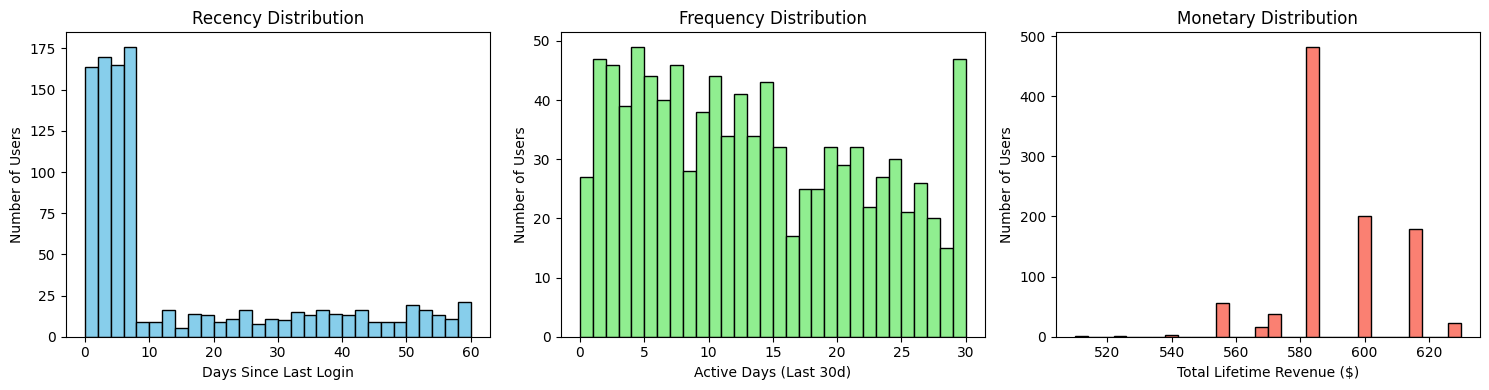

In [5]:
#Visualizing RFM sistributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Recency distribution
axes[0].hist(rfm_df['rfm_recency'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days Since Last Login')
axes[0].set_ylabel('Number of Users')

# Frequency distribution
axes[1].hist(rfm_df['rfm_frequency'], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Active Days (Last 30d)')
axes[1].set_ylabel('Number of Users')

# Monetary distribution
axes[2].hist(rfm_df['rfm_monetary'], bins=30, color='salmon', edgecolor='black')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Total Lifetime Revenue ($)')
axes[2].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

In [6]:
#Calculating RFM scores (1-5)
def calculate_rfm_scores(rfm_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate quintile-based RFM scores (1-5) for each metric.
    
    Scoring logic:
    - Recency: Lower values (more recent) get higher scores (5)
    - Frequency: Higher values (more frequent) get higher scores (5)
    - Monetary: Higher values (more lifetime revenue) get higher scores (5)
    """
    rfm_scored = rfm_df.copy()
    
    # Recency scoring: Lower recency => better
    try:
        rfm_scored['rfm_r_score'] = pd.qcut(
            rfm_scored['rfm_recency'], 
            q=5, 
            labels=[5, 4, 3, 2, 1],
            duplicates='drop'
        )
    except ValueError:
        print("Not enough unique recency values, using rank-based scoring")
        rfm_scored['rfm_r_score'] = pd.cut(
            rfm_scored['rfm_recency'].rank(method='first'),
            bins=5,
            labels=[5, 4, 3, 2, 1]
        )
    
    # Frequency scoring: Higher frequency => better
    try:
        rfm_scored['rfm_f_score'] = pd.qcut(
            rfm_scored['rfm_frequency'], 
            q=5, 
            labels=[1, 2, 3, 4, 5],
            duplicates='drop'
        )
    except ValueError:
        print("Not enough unique frequency values, using rank-based scoring")
        rfm_scored['rfm_f_score'] = pd.cut(
            rfm_scored['rfm_frequency'].rank(method='first'),
            bins=5,
            labels=[1, 2, 3, 4, 5]
        )
    
    # Monetary scoring: Higher revenue => better
    try:
        rfm_scored['rfm_m_score'] = pd.qcut(
            rfm_scored['rfm_monetary'], 
            q=5, 
            labels=[1, 2, 3, 4, 5],
            duplicates='drop'
        )
    except ValueError:
        print("Not enough unique monetary values, using rank-based scoring")
        rfm_scored['rfm_m_score'] = pd.cut(
            rfm_scored['rfm_monetary'].rank(method='first'),
            bins=5,
            labels=[1, 2, 3, 4, 5]
        )
    
    rfm_scored['rfm_r_score'] = rfm_scored['rfm_r_score'].astype(int)
    rfm_scored['rfm_f_score'] = rfm_scored['rfm_f_score'].astype(int)
    rfm_scored['rfm_m_score'] = rfm_scored['rfm_m_score'].astype(int)
    
    # RFM segment string ("555", "432", "111")
    rfm_scored['rfm_segment'] = (
        rfm_scored['rfm_r_score'].astype(str) + 
        rfm_scored['rfm_f_score'].astype(str) + 
        rfm_scored['rfm_m_score'].astype(str)
    )
    
    print(f"Calculated RFM scores for {len(rfm_scored)} users")
    print(f"\nR-Score distribution:\n{rfm_scored['rfm_r_score'].value_counts().sort_index()}")
    print(f"\nF-Score distribution:\n{rfm_scored['rfm_f_score'].value_counts().sort_index()}")
    print(f"\nM-Score distribution:\n{rfm_scored['rfm_m_score'].value_counts().sort_index()}")
    
    return rfm_scored
    
rfm_scored = calculate_rfm_scores(rfm_df)
rfm_scored.head(10)


Not enough unique monetary values, using rank-based scoring
Calculated RFM scores for 1000 users

R-Score distribution:
rfm_r_score
1    199
2    126
3    253
4    183
5    239
Name: count, dtype: int64

F-Score distribution:
rfm_f_score
1    208
2    196
3    196
4    214
5    186
Name: count, dtype: int64

M-Score distribution:
rfm_m_score
1    200
2    200
3    200
4    200
5    200
Name: count, dtype: int64


,user_key,rfm_recency,rfm_frequency,subscription_plan_key,rfm_monetary,rfm_r_score,rfm_f_score,rfm_m_score,rfm_segment
0,750,5,11,4,584.92,3,3,1,331
1,981,58,6,5,554.93,1,2,1,121
2,905,4,15,1,584.92,4,4,1,441
3,866,5,3,4,584.92,3,1,1,311
4,522,15,10,4,584.92,2,3,1,231
5,374,54,2,1,614.91,1,1,4,114
6,769,1,29,1,584.92,5,5,1,551
7,924,1,30,1,569.92,5,5,1,551
8,383,44,0,1,614.91,1,1,4,114
9,619,1,15,2,584.92,5,4,1,541


In [7]:
#Assigning segment labels (suited to our educational platform)
def assign_segment_labels(rfm_df: pd.DataFrame) -> pd.DataFrame:
    """
    Assign education-focused segment labels based on RFM scores.
    Optimized for premium learner retention and engagement.
    """
    rfm_labeled = rfm_df.copy()
    
    def segment_customer(row):
        r, f, m = row['rfm_r_score'], row['rfm_f_score'], row['rfm_m_score']
        
        # Active High-Value Learners: Best premium students - highly engaged, recent, paid multiple cycles
        if r >= 4 and f >= 4 and m >= 4:
            return 'Active High-Value Learners'
        
        # Engaged Subscribers: Regular learners with consistent engagement
        elif r >= 4 and f >= 3 and m >= 3:
            return 'Engaged Subscribers'
        
        # New Premium Users: Recently joined, still building habits
        elif r >= 4 and f <= 2 and m <= 2:
            return 'New Premium Users'
        
        # Loyal Long-Term: May not be super recent but have high frequency and monetary
        # These are our steady, committed learners
        elif f >= 4 and m >= 4 and r >= 2:
            return 'Loyal Long-Term'
        
        # Promising Starters: Moderate engagement, growing potential
        elif r >= 3 and f >= 2 and m >= 2:
            return 'Promising Starters'
        
        # Declining Engagement: Were active but frequency/recency dropping
        # High intervention priority
        elif f >= 3 and r <= 2:
            return 'Declining Engagement'
        
        # High-Value at Risk: Paid a lot but haven't been active recently
        # Critical to re-engage before they cancel
        elif m >= 4 and r <= 2:
            return 'High-Value at Risk'
        
        # Casual Users: Low engagement across the board but still premium
        elif r >= 2 and f <= 2 and m <= 2:
            return 'Casual Users'
        
        # Dormant Premium: Haven't engaged in a while, likely to churn
        elif r <= 2 and f <= 2:
            return 'Dormant Premium'
        
        # Recently Churned: Very low recency, low engagement
        # Need win-back campaigns
        else:
            return 'Recently Churned'
    
    rfm_labeled['segment_label'] = rfm_labeled.apply(segment_customer, axis=1)
    
    segment_counts = rfm_labeled['segment_label'].value_counts()
    print("Premium Learner Segments Assigned\n")
    print("Segment Distribution:")
    print("="*70)
    for segment, count in segment_counts.items():
        pct = (count / len(rfm_labeled)) * 100
        print(f"{segment:30s}: {count:5d} learners ({pct:5.1f}%)")
    print("="*70)
    
    print("\nSegment Definitions:")
    print("-" * 70)
    segment_info = {
        'Active High-Value Learners': 'Top tier: Highly engaged, recent activity, multiple renewals',
        'Engaged Subscribers': 'Strong engagement with regular platform usage',
        'New Premium Users': 'Recently upgraded, still forming learning habits',
        'Loyal Long-Term': 'Committed learners with long subscription history',
        'Promising Starters': 'Moderate engagement, potential to become loyal',
        'Declining Engagement': 'Previously active but participation dropping - intervention needed',
        'High-Value at Risk': 'Paid subscribers with declining activity - critical retention target',
        'Casual Users': 'Minimal engagement despite premium status',
        'Dormant Premium': 'Inactive but still subscribed - likely to cancel',
        'Recently Churned': 'No recent activity - candidates for win-back campaigns'
    }
    
    for segment in rfm_labeled['segment_label'].unique():
        if segment in segment_info:
            count = segment_counts.get(segment, 0)
            print(f"\n{segment} ({count} learners):")
            print(f"  → {segment_info[segment]}")
    print("-" * 70)
    
    return rfm_labeled

rfm_final = assign_segment_labels(rfm_scored)
rfm_final.head(10)


Premium Learner Segments Assigned

Segment Distribution:
Promising Starters            :   198 learners ( 19.8%)
Recently Churned              :   152 learners ( 15.2%)
Declining Engagement          :   116 learners ( 11.6%)
High-Value at Risk            :    93 learners (  9.3%)
Active High-Value Learners    :    92 learners (  9.2%)
Engaged Subscribers           :    90 learners (  9.0%)
Dormant Premium               :    85 learners (  8.5%)
Loyal Long-Term               :    65 learners (  6.5%)
New Premium Users             :    55 learners (  5.5%)
Casual Users                  :    54 learners (  5.4%)

Segment Definitions:
----------------------------------------------------------------------

Recently Churned (152 learners):
  → No recent activity - candidates for win-back campaigns

Dormant Premium (85 learners):
  → Inactive but still subscribed - likely to cancel

Casual Users (54 learners):
  → Minimal engagement despite premium status

Declining Engagement (116 learners):

,user_key,rfm_recency,rfm_frequency,subscription_plan_key,rfm_monetary,rfm_r_score,rfm_f_score,rfm_m_score,rfm_segment,segment_label
0,750,5,11,4,584.92,3,3,1,331,Recently Churned
1,981,58,6,5,554.93,1,2,1,121,Dormant Premium
2,905,4,15,1,584.92,4,4,1,441,Recently Churned
3,866,5,3,4,584.92,3,1,1,311,Casual Users
4,522,15,10,4,584.92,2,3,1,231,Declining Engagement
5,374,54,2,1,614.91,1,1,4,114,High-Value at Risk
6,769,1,29,1,584.92,5,5,1,551,Recently Churned
7,924,1,30,1,569.92,5,5,1,551,Recently Churned
8,383,44,0,1,614.91,1,1,4,114,High-Value at Risk
9,619,1,15,2,584.92,5,4,1,541,Recently Churned


In [8]:
#Saving RFM snapshot to the database
#Current date
snapshot_date_key = int(datetime.now().strftime("%Y%m%d"))

rfm_snapshot = rfm_final.copy()
rfm_snapshot['snapshot_date_key'] = snapshot_date_key

# Columns not yet computed are set to None
rfm_snapshot['kmeans_cluster'] = None
rfm_snapshot['kmeans_segment_label'] = None
rfm_snapshot['churn_probability'] = None
rfm_snapshot['churn_risk_band'] = None
rfm_snapshot['survival_median_time_to_downgrade'] = None
rfm_snapshot['survival_risk_90d'] = None
rfm_snapshot['clv_value'] = None
rfm_snapshot['clv_band'] = None
rfm_snapshot['model_version'] = 'v1.0'

#Calculating engagement_level from segment_label for frontend
def assign_engagement_level(segment_label):
    highly_engaged = ['Active High-Value Learners', 'Engaged Subscribers', 'Loyal Long-Term']
    medium_engaged = ['Promising Starters', 'New Premium Users', 'Casual Users']
    at_risk = ['Declining Engagement', 'High-Value at Risk']
    dormant = ['Dormant Premium', 'Recently Churned']
    
    if segment_label in highly_engaged:
        return 'Highly Engaged'
    elif segment_label in medium_engaged:
        return 'Medium Engaged'
    elif segment_label in at_risk:
        return 'At Risk'
    elif segment_label in dormant:
        return 'Dormant'
    else:
        return 'Unknown'

rfm_snapshot['engagement_level'] = rfm_snapshot['segment_label'].apply(assign_engagement_level)

rfm_snapshot = rfm_snapshot[[
    'user_key',
    'snapshot_date_key',
    'subscription_plan_key',
    'rfm_recency',
    'rfm_frequency',
    'rfm_monetary',
    'rfm_r_score',
    'rfm_f_score',
    'rfm_m_score',
    'rfm_segment',                     
    'segment_label',                     
    'engagement_level',                
    'kmeans_cluster',
    'kmeans_segment_label',
    'churn_probability',
    'churn_risk_band',
    'survival_median_time_to_downgrade',
    'survival_risk_90d',
    'clv_value',
    'clv_band',
    'model_version'
]]

print(f"\nSnapshot prepared with {len(rfm_snapshot)} records")
print(f"Snapshot date: {snapshot_date_key}")
print(f"\nColumns: {len(rfm_snapshot.columns)} total")

with SessionLocal() as session:
    ensure_snapshot_date(session, snapshot_date_key)

save_snapshot_to_db(rfm_snapshot)

print("\n" + "="*80)
print("RFM ANALYSIS SAVED TO DATABASE!")
print(f"Table: fact_user_analytics_snapshot")
print(f"Records saved: {len(rfm_snapshot)}")
print(f"Snapshot date: {snapshot_date_key}")
print("="*80)

print("\nSegment Label Distribution:")
for segment, count in rfm_snapshot['segment_label'].value_counts().items():
    pct = (count / len(rfm_snapshot)) * 100
    print(f"  {segment:35s}: {count:4d} ({pct:5.1f}%)")

print("\nEngagement Level Distribution:")
for level, count in rfm_snapshot['engagement_level'].value_counts().items():
    pct = (count / len(rfm_snapshot)) * 100
    print(f"  {level:20s}: {count:4d} ({pct:5.1f}%)")



Snapshot prepared with 1000 records
Snapshot date: 20251128

Columns: 21 total


2025-11-28 18:10:57.052 | INFO     | helpers:save_snapshot_to_db:118 - Saved analytics snapshot to table: fact_user_analytics_snapshot



RFM ANALYSIS SAVED TO DATABASE!
Table: fact_user_analytics_snapshot
Records saved: 1000
Snapshot date: 20251128

Segment Label Distribution:
  Promising Starters                 :  198 ( 19.8%)
  Recently Churned                   :  152 ( 15.2%)
  Declining Engagement               :  116 ( 11.6%)
  High-Value at Risk                 :   93 (  9.3%)
  Active High-Value Learners         :   92 (  9.2%)
  Engaged Subscribers                :   90 (  9.0%)
  Dormant Premium                    :   85 (  8.5%)
  Loyal Long-Term                    :   65 (  6.5%)
  New Premium Users                  :   55 (  5.5%)
  Casual Users                       :   54 (  5.4%)

Engagement Level Distribution:
  Medium Engaged      :  307 ( 30.7%)
  Highly Engaged      :  247 ( 24.7%)
  Dormant             :  237 ( 23.7%)
  At Risk             :  209 ( 20.9%)


# KPI METRICS - UPDATING dashboard_metrics

In [10]:
#Calculating KPI Metrics 

def calculate_dashboard_metrics(rfm_df: pd.DataFrame, snapshot_date_key: int):
    """
    Calculate all dashboard KPIs from RFM analysis
    Filters for premium (Standard + Premium tier) users only
    """
    # subscription_plan_key: 1 = Free, 2-3 = Standard, 4-5 = Premium
    premium_df = rfm_df[rfm_df['subscription_plan_key'].isin([2, 3, 4, 5])].copy()
    total_learners = len(premium_df)
    
    if total_learners == 0:
        print("No premium learners found!")
        return None
    
    active_premium = len(premium_df[premium_df['rfm_recency'] <= 7])
    
    at_risk_segments = ['High-Value at Risk', 'Declining Engagement', 'Dormant Premium']
    at_risk = len(premium_df[premium_df['segment_label'].isin(at_risk_segments)])
    
    retained_segments = [
        'Active High-Value Learners',
        'Engaged Subscribers',
        'Loyal Long-Term',
        'Promising Starters'
    ]
    retained = len(premium_df[premium_df['segment_label'].isin(retained_segments)])
    retention_rate = (retained / total_learners * 100)
    
    churned = len(premium_df[premium_df['segment_label'] == 'Recently Churned'])
    new_users = len(premium_df[premium_df['segment_label'] == 'New Premium Users'])
    
    highly_engaged_segments = ['Active High-Value Learners', 'Engaged Subscribers', 'Loyal Long-Term']
    medium_engaged_segments = ['Promising Starters', 'New Premium Users', 'Casual Users']
    at_risk_segments_eng = ['Declining Engagement', 'High-Value at Risk']
    dormant_segments = ['Dormant Premium', 'Recently Churned']
    
    highly_engaged = len(premium_df[premium_df['segment_label'].isin(highly_engaged_segments)])
    medium_engaged = len(premium_df[premium_df['segment_label'].isin(medium_engaged_segments)])
    at_risk_eng = len(premium_df[premium_df['segment_label'].isin(at_risk_segments_eng)])
    dormant = len(premium_df[premium_df['segment_label'].isin(dormant_segments)])
    
    monthly_retention_rate = retention_rate
    monthly_churn_rate = (dormant / total_learners * 100)
    
    metrics = {
        'snapshot_date_key': snapshot_date_key,
        
        # Core KPIs
        'active_premium_learners': active_premium,
        'at_risk_learners': at_risk,
        'average_retention_rate': round(retention_rate, 2),
        'total_premium_learners': total_learners,
        'churned_learners': churned,
        'new_premium_learners': new_users,
        
        # Monthly trends
        'monthly_retention_rate': round(monthly_retention_rate, 1),
        'monthly_churn_rate': round(monthly_churn_rate, 1),
        
        # Engagement segmentation
        'highly_engaged_count': highly_engaged,
        'highly_engaged_pct': round((highly_engaged / total_learners * 100), 1),
        'medium_engaged_count': medium_engaged,
        'medium_engaged_pct': round((medium_engaged / total_learners * 100), 1),
        'at_risk_count': at_risk_eng,
        'at_risk_pct': round((at_risk_eng / total_learners * 100), 1),
        'dormant_count': dormant,
        'dormant_pct': round((dormant / total_learners * 100), 1),
        
        # Changes
        'active_premium_change_pct': None,
        'at_risk_change_count': None,
        'retention_rate_change_pct': None
    }
    
    print("="*80)
    print("DASHBOARD METRICS CALCULATED (PAID SUBSCRIPTIONS ONLY)")
    print("="*80)
    
    tier_breakdown = premium_df['subscription_plan_key'].value_counts().sort_index()
    plan_names = {
        2: "Standard Monthly",
        3: "Standard Annual", 
        4: "Premium Monthly",
        5: "Premium Annual"
    }
    
    print(f"\nSubscription Breakdown:")
    for plan_key, count in tier_breakdown.items():
        print(f"  {plan_names.get(plan_key, f'Plan {plan_key}'):20s}: {count:,} learners")
    
    print(f"\nCore KPIs:")
    print(f"  Active Premium Learners:    {active_premium:,} ({active_premium/total_learners*100:.1f}%)")
    print(f"    → Recent activity (≤7 days) + Paid subscription")
    print(f"  At-Risk Learners:           {at_risk:,} ({at_risk/total_learners*100:.1f}%)")
    print(f"  Average Retention Rate:     {retention_rate:.1f}%")
    print(f"  Total Premium Learners:     {total_learners:,}")
    print(f"  New Premium Users:          {new_users:,}")
    print(f"  Churned Learners:           {churned:,}")
    
    print(f"\nMonthly Trends:")
    print(f"  Retention Rate:             {monthly_retention_rate:.1f}%")
    print(f"  Churn Rate:                 {monthly_churn_rate:.1f}%")
    
    print(f"\nEngagement Distribution:")
    print(f"  Highly Engaged:             {highly_engaged:,} ({metrics['highly_engaged_pct']}%)")
    print(f"  Medium Engaged:             {medium_engaged:,} ({metrics['medium_engaged_pct']}%)")
    print(f"  At Risk:                    {at_risk_eng:,} ({metrics['at_risk_pct']}%)")
    print(f"  Dormant:                    {dormant:,} ({metrics['dormant_pct']}%)")
    print("="*80)
    
    return metrics
    
dashboard_metrics = calculate_dashboard_metrics(rfm_final, snapshot_date_key)

#Saving dashboard metrics to database
save_dashboard_metrics_to_db(dashboard_metrics)

2025-11-28 18:11:50.540 | INFO     | helpers:save_dashboard_metrics_to_db:147 - Dashboard metrics saved to database for snapshot 20251128


DASHBOARD METRICS CALCULATED (PAID SUBSCRIPTIONS ONLY)

Subscription Breakdown:
  Standard Monthly    : 204 learners
  Standard Annual     : 211 learners
  Premium Monthly     : 195 learners
  Premium Annual      : 192 learners

Core KPIs:
  Active Premium Learners:    551 (68.7%)
    → Recent activity (≤7 days) + Paid subscription
  At-Risk Learners:           224 (27.9%)
  Average Retention Rate:     44.8%
  Total Premium Learners:     802
  New Premium Users:          50
  Churned Learners:           122

Monthly Trends:
  Retention Rate:             44.8%
  Churn Rate:                 22.9%

Engagement Distribution:
  Highly Engaged:             202 (25.2%)
  Medium Engaged:             254 (31.7%)
  At Risk:                    162 (20.2%)
  Dormant:                    184 (22.9%)
